# DETECT: tutorial

Developed by Tobias Géron at the University of Toronto.

This code was developed to help better quantify detection thresholds with the Rubin pipelines. The current Rubin pipelines define detections with a simple SNR threshold. However, this becomes difficult when there is a bright background galaxy, or when the datapoint in question has a magnitude around the detection threshold (~23-24). How confident are we that this detection is real? This code was created with a specific science goal in mind: pre-SN variability. However, it can be used in any science context where you want to better understand the detection thresholds. This code helps to answer the following question: "Using the Rubin pipelines, in this specific epoch, using this specific template, how likely is it that a datapoint of X mag is detected?" 

This is answered using a series of source injection (see Parts I-II), image subtraction (see Part III), and forced photometry (see Part IV). This is repeated for multiple injection locations and multiple magnitude ranges. The output of the pipeline is a recovery curve (see Part VII), which you can use to compute the 80% or 50% detection fraction thresholds (i.e. the magnitude where X% of sources with magnitude Y would be detected with the Rubin pipelines at this specific epoch and this specific template; see Part VIII).

This is an short tutorial on how to use this package, where we only discuss the basics. For a more in-depth tutorial that covers and explains some of the logic behind the code, go to `tutorial.ipynb`. 

### Import packages, and config
Before we start, we must import everything we need. We use a lot of packages, both part of the Rubin pipeline and others.

In [1]:
from detect import * # Import all functions

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

# Various Rubin pipelines
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

In [2]:
# Additional config
service = get_tap_service("tap")
assert service is not None

butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

afwDisplay.setDefaultBackend('matplotlib')

set_logging_level('WARNING')

### Part 0: Load data

In this first part, we will load some data from DP1 to run this pipeline on. In this scenario, we have a specific RA/Dec pair that we are interested in. Let's query the `DiaObject` table at those coordinates to see whether Rubin has found something there. If nothing is found, then Rubin will also not have done forced photometry on this location. This makes things a bit more complicated. To get around this, you could query all visit_images that cover that RA/Dec pair, and just do forced photometry yourself. But in this tutorial, we will assume that we have found a valid diaObjectId.

In [3]:
ra_sn, dec_sn = 58.335054, -48.750303

band = 'r'

In [4]:
query = "SELECT ra, dec, diaObjectId "\
        "FROM dp1.DiaObject "\
        f"WHERE CONTAINS (POINT('ICRS', ra, dec), CIRCLE('ICRS',{ra_sn}, {dec_sn}, {10/60/60})) = 1 "

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

df_diaobj = job.fetch_result().to_table()
print(f"\nFound {len(df_diaobj)} source(s)")

Job phase is COMPLETED

Found 1 source(s)


In [5]:
df_diaobj

ra,dec,diaObjectId
deg,deg,
float64,float64,int64
58.334939507315646,-48.75027587334623,592914119179370575


In [6]:
# Select the correct object
diaobjectid = df_diaobj['diaObjectId'][0]

We will now use that `diaObjectId` to query the `ForcedSourceOnDiaObject` table to obtain the light curve around that object. 

In [7]:
query = "SELECT fsodo.coord_ra, fsodo.coord_dec, fsodo.diaObjectId, fsodo.visit, fsodo.detector, fsodo.band, vis.skyRotation, "\
        "fsodo.tract, fsodo.patch, fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, fsodo.psfFlux, fsodo.psfFluxErr, vis.expMidptMJD "\
        "FROM dp1.ForcedSourceOnDiaObject as fsodo "\
        "JOIN dp1.Visit as vis ON vis.visit = fsodo.visit "\
        f"WHERE fsodo.diaObjectId = {diaobjectid} AND fsodo.band = '{band}'"

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

df_exposure = job.fetch_result().to_table()
print(f"\nFound {len(df_exposure)} sources")

Job phase is COMPLETED

Found 10 sources


In [8]:
# Adding some extra columns...
df_exposure['psfDiffMag'] = njy_to_mag(df_exposure['psfDiffFlux'])
df_exposure['psfDiff_snr'] = df_exposure['psfDiffFlux'] / df_exposure['psfDiffFluxErr']
df_exposure['detected'] = [True if df_exposure['psfDiffFlux'][i] - 5* df_exposure['psfDiffFluxErr'][i] > 0 else False for i in range(len(df_exposure))]
df_exposure['5sigma_mag'] = njy_to_mag(5* df_exposure['psfDiffFluxErr'])
df_exposure['5sigma_flux'] = 5* df_exposure['psfDiffFluxErr']
df_exposure = df_exposure.to_pandas()

df_exposure.head()

,coord_ra,coord_dec,diaObjectId,visit,detector,band,skyRotation,tract,patch,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,expMidptMJD,psfDiffMag,psfDiff_snr,detected,5sigma_mag,5sigma_flux
0,58.33494,-48.750276,592914119179370575,2024120800420,2,r,53.504779,2394,28,3085.929932,200.940002,10593.000000,193.145996,60653.233153,22.676535,15.357470,True,23.894909,1004.700012
1,58.33494,-48.750276,592914119179370575,2024111800097,8,r,293.702197,2394,28,-736.094971,194.270004,7324.600098,183.860992,60633.099718,NaN,-3.789031,False,23.931561,971.350021
2,58.33494,-48.750276,592914119179370575,2024111700344,2,r,68.683768,2394,28,-493.553009,339.725006,7918.330078,334.776001,60632.234874,NaN,-1.452802,False,23.324756,1698.625031
3,58.33494,-48.750276,592914119179370575,2024112600182,8,r,293.090221,2394,28,-563.911011,138.395996,3009.510010,123.559998,60641.120656,NaN,-4.074619,False,24.299766,691.979980
4,58.33494,-48.750276,592914119179370575,2024112600183,8,r,293.231112,2394,28,-794.838989,125.908997,2324.969971,112.601997,60641.121511,NaN,-6.312805,False,24.402433,629.544983


In [9]:
# Remove duplicate days to make it clearer
df_exposure['mjd_int'] = df_exposure['expMidptMJD'].astype(int)
df_exposure = df_exposure[df_exposure.duplicated(subset = 'mjd_int', keep = 'first') == False].reset_index(drop=True)
df_exposure = df_exposure.drop(columns=['mjd_int'])

# Sort by mjd
df_exposure = df_exposure.sort_values(by='expMidptMJD').reset_index(drop=True)

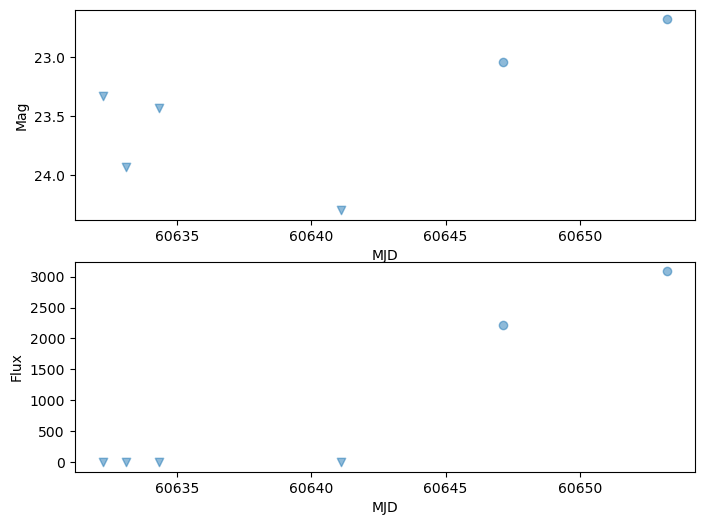

In [10]:
c = 'C0'

plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['psfDiffMag'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['5sigma_mag'][i], marker = 'v', c = c, alpha = 0.5)
        

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Mag')


plt.subplot(2,1,2)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['psfDiffFlux'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['expMidptMJD'][i], mag_to_njy(df_exposure['5sigma_flux'][i]), marker = 'v', c = c, alpha = 0.5)
        
plt.xlabel('MJD')
plt.ylabel('Flux')

plt.show()

Select one specific epoch to run the code on.

In [11]:
i = 5

mjd = df_exposure['expMidptMJD'][i]
visit = df_exposure['visit'][i]
detector = df_exposure['detector'][i]
tract = df_exposure['tract'][i]
patch = df_exposure['patch'][i]
dataId = {'band' : band, 'visit': visit, 'detector': detector, 'tract' : tract, 'patch' : patch}

# Get calexp, template and sources from butler
calexp = butler.get('visit_image', dataId=dataId)
template = butler.get('template_coadd', dataId=dataId)
diff = butler.get('difference_image', dataId=dataId)

# Obtain all the sources in the calexp. These are used later, but it is best to load them now. 
sources = source_detection(calexp)

# Get the SN mag from df_exposure. Can be either actual value, or 5sigma detection. Doesn't matter too much,
# the final code will only use this as an initial estimate.
sn_mag = df_exposure['psfDiffMag'][i] if df_exposure['detected'][i] else df_exposure['5sigma_mag'][i]

We visualise the images below. It is often good practice to visually inspect your cutouts to make sure that nothing is obviously wrong. Things to look out for include making sure that your galaxy is on the edge of the image, and that the template does not contain any obvious artifacts. Note that the template image might be oriented differently compared to the science image. This is because, by default, the templates and visit images are located on different grids. This can easily be solved by warping the template image using: 

```
warped_template = warp_exposure(template,calexp)
```

However, we do this automatically inside our pipeline when needed, so we do not worry about this here.

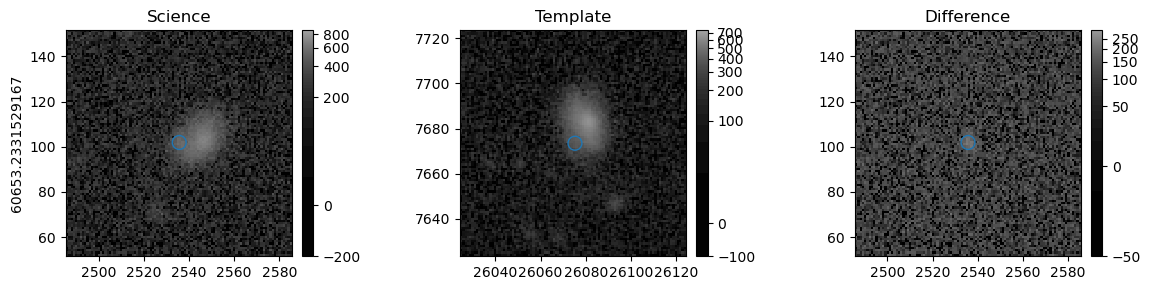

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

plot_image(calexp, ax = ax[0], title = f'Science', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 20, scale = 'asinh')
plt.ylabel(mjd)
plot_image(template, ax = ax[1], title = f'Template', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 20, scale = 'asinh')
plot_image(diff, ax = ax[2], title = f'Difference', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 20, scale = 'asinh')

plt.tight_layout()
plt.show()

Finally, we also create cutouts to speed up our code.

In [13]:
cutout_size = 400 #in arcsec
calexp_cutout = cutout_exposure(calexp, ra_sn, dec_sn, size = cutout_size, size_units = 'sky')
template_cutout = cutout_exposure(template, ra_sn, dec_sn, size = cutout_size+20, size_units = 'sky') #templates have a buffer region around edges. Need to account for that, hence the +20
diff_cutout = cutout_exposure(diff, ra_sn, dec_sn, size = cutout_size, size_units = 'sky')

Now we're ready to go!

### Part I: Estimate background noise

Before we continue, we need to talk about image subtraction a bit more. The subtraction pipeline is not perfect. Image subtraction is a difficult problem, especially when there is a bright background galaxy. The Rubin pipelines sometimes register some pixels as detections (SNR > 5 in the difference image), even when there is not anything there. To investigate whether this is the case for your particular image, you can use `measure_snr_on_img()`.

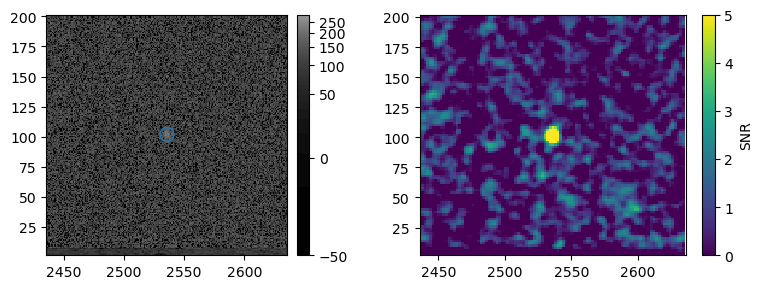

In [15]:
_ = measure_snr_on_img(diff_cutout, (ra_sn,dec_sn), zoom_size = 40, stepsize = 2, plot = True)


There can be a lot of detections at various places in this image, even when there shouldn't be. This isn't always the case, but typically happens when the background galaxy is very bright. This will affect both the original SN measurement made by the Rubin pipelines, as well as the measurements we make ourselves. We can estimate the contribution of this issue on the original SN measurement. This is done by finding all pixels that have similar flux values to the SN site in the template image, measuring what flux they have in the science image, and use that to correct the SN flux. This is done with the `estimate_sn_background()` function. Ideally you want the background flux to be centered around zero. But if it isn't, then you can subtract the median from the sn mag.

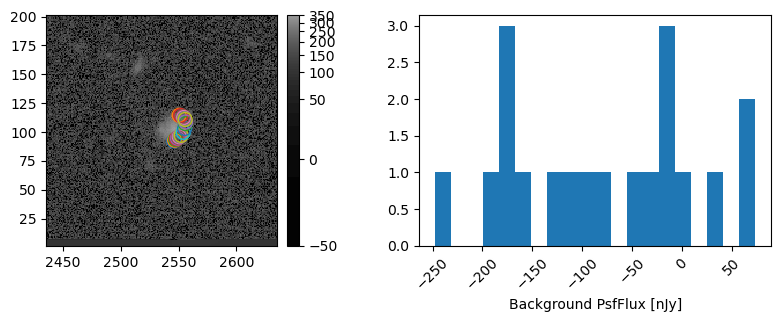

In [16]:
df_background = estimate_sn_background(calexp, template, sources = sources, sn_position = (ra_sn,dec_sn),
                             p_threshold = 5, plot = True, cutout_size = cutout_size)

# First convert SN magnitudes to nJy, then subtract median (or mean) of the background, then convert back to mag. 
sn_njy = mag_to_njy(sn_mag) - np.median(df_background['base_PsfFlux_nJy'])
sn_mag_new = njy_to_mag(sn_njy)

In [17]:
df_background.head()

,base_PsfFlux_nJy,base_PsfFlux_nJyErr,injection_id,injection_ra,injection_dec
0,-247.333855,191.895202,0_0,58.333898,-48.750157
1,-198.104637,192.382547,0_1,58.333899,-48.750101
2,-127.273760,192.730217,0_2,58.333900,-48.750046
3,-75.618573,193.178637,0_3,58.333901,-48.749990
4,31.447721,193.557386,0_4,58.333902,-48.749935


### Part II: Create a recovery curve
We are almost there! The goal of this package is to generate a recovery curve. We can do that manually by calling `inject_subtract_photometry()` multiple times for different magnitudes (sn_mags), and checking what fraction of injected sources are detected at each value of sn_mag. However, this is done automatically with the `recovery_curve()` function. 

This function needs the sn_mag, the science exposure, the template exposure, the other sources in the image and the SN position as inputs. Additional settings can be adjusted through the `recovery_curve_config` class. 

There are a lot of settings that can be tweaked, but we'll go through some important ones here. The `recovery_curve()` fuction creates a range of sn magnitudes to check. It is important to sample the transition region where the detection fraction goes from 1 to 0. This is done in different steps defined by the `n_mag_steps`. E.g., if n_mag_steps = [4,10], it'll first sample 4 magnitudes. It'll then zoom further in and sample 10 magnitudes in the next iteration. The default is [4,4,4,8,20]. This means it'll first sample 4 magnitudes, then zoom in and sample another 4, then another 4, another 8, and finally 20. The precision on the detection fraction depends on `n_injections`. If n_injections = 10, then we will only be precise with steps of 0.1 (i.e. 1/n_injections). The default is 10. Additionally, `cutout_size` determines the size of the cutout. As discussed above, smaller cutouts significantly speed things up, but we still need enough sources in the image to properly do the subtraction. The default option is to not use a cutout, but we strongly suggest to change this to your needs. In this case, a cutout_size of 400 arcsec seems to do the job. Additionally, as covered above, the subtraction pipeline doesn't always work perfectly. Some injection locations will always register as detections. We can account for that using the `subtract_background` parameter (default is True). If enabled, we first measure the baseline background before injecting fake sources and then subtract that from the measured value before determining whether the injected source is detected. Finally, the `n_jobs` parameter is used to parallelise the code. It should not exceed the number of available CPU cores.

Running this might take a few minutes per epoch. The `n_mag_steps`, `n_injection`, `cutout_size` and `n_jobs` parameters are the most important arguments to finetune if the pipeline takes too long. The biggest time sink is the Rubin image subtraction. Unfortunately, the nature of this pipeline requires us to use that, so we cannot make any improvements there. 

The `recovery_curve()` function returns a pandas DataFrame where every row represents a magnitude (`sn_mag`) and in what fraction of injections this was recovered (`detected`). You can expand the output of this function by doing `expand_output = True`, in which case a more detailed DataFrame is returned. In this case, each row represents a single injection location over a single inject sn magnitude. For most purposes, the smaller table is good enough. You can obtain the former (concise) table from from the latter (extended) table by doing: 

`df_summary = recovery_summary(df_recovery)`

Finally, it is good practice to pass the complete images you obtain from Rubin. We create cutouts within the function where appropriate. This also ensures that the wcs of each image behaves as expected.

Note that this may take a while to run. 

  0%|          | 0/5 [00:00<?, ?it/s]

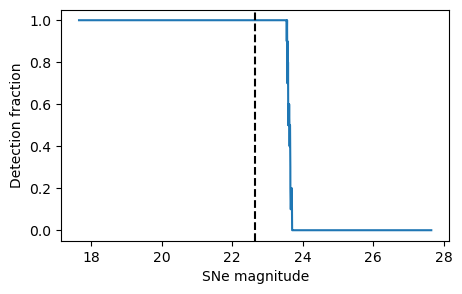

In [18]:
config = recovery_curve_config()

# General config
config.plot = True
config.n_injection = 10 
config.n_mag_steps = [4,4,4,8,20]
config.cutout_size = 400 # Strongly encouraged to add cutout size to speed things up.
config.n_jobs = 4 # Assuming we have 4 cores available. 


# Config to select injection locations. The values for these parameters are explained in more detail in the longer, in-depth tutorial.
config.p_threshold = 5
config.psf_flux_threshold =  0.001
config.psf_sigma = 0
config.min_dist_across_iterations = 0.4
config.max_dist = 20


df_recovery = recovery_curve(sn_mag = sn_mag_new, science_exposure = calexp, template_exposure = template, 
                sources = sources, sn_position = (ra_sn,dec_sn), config = config)

In [19]:
df_recovery.head()

,sn_mag,base_PsfFlux_nJy,base_PsfFlux_nJyErr,base_PsfFlux_SNR,detected,background_nonzero_flag
0,17.650250,326161.718947,272.841779,1195.436697,1.0,0.0
1,20.983584,15213.224507,272.839351,55.759593,1.0,0.0
2,22.650250,3321.500578,272.839215,12.174508,1.0,0.0
3,22.983584,2446.207308,272.839277,8.965703,1.0,0.0
4,23.316917,1760.129392,272.839241,6.451611,1.0,0.0


We can then estimate any detection threshold from the recovery curve (typically the 50% or the 80% detection fraction). This is done as follows:

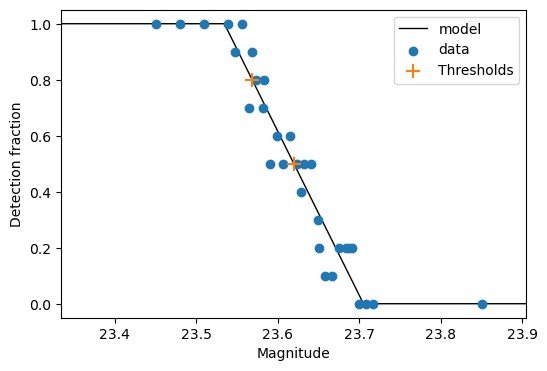

In [20]:
mag_limits = find_thresholds(df_recovery,detection_fraction_thresholds = [0.5,0.8], plot = True)

In [21]:
mag_limits

{'lim_0.5': np.float64(23.619683410240484),
 'lim_0.8': np.float64(23.568445027359985)}

We can then compare these values to the sn magnitude (that is corrected for potential background flux) to decide whether we trust it. 

In [22]:
sn_mag_new

np.float64(22.650250186558473)

For a more in-depth tutorial, please see `tutorial.ipynb`.